Cluster: Cluster 0 - total_spend
Normalized Scale -> RMSE: 0.1456, MAE: 0.1070, R²: 0.9897
----------------------------------------


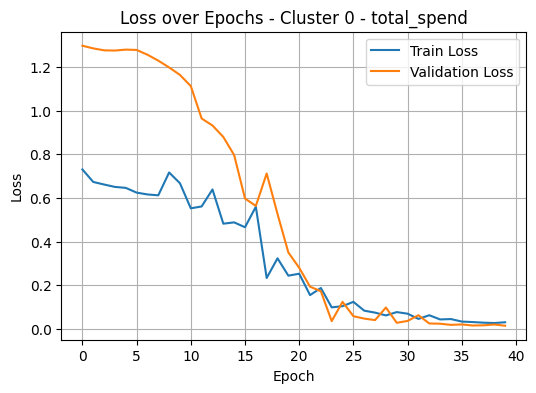

Cluster: Cluster 1 - total_spend
Normalized Scale -> RMSE: 0.2188, MAE: 0.1660, R²: 0.6362
----------------------------------------


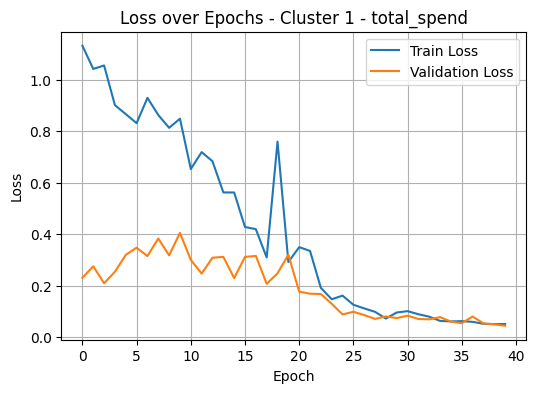

Cluster: Cluster 2 - total_spend
Normalized Scale -> RMSE: 0.4272, MAE: 0.2481, R²: 0.4402
----------------------------------------


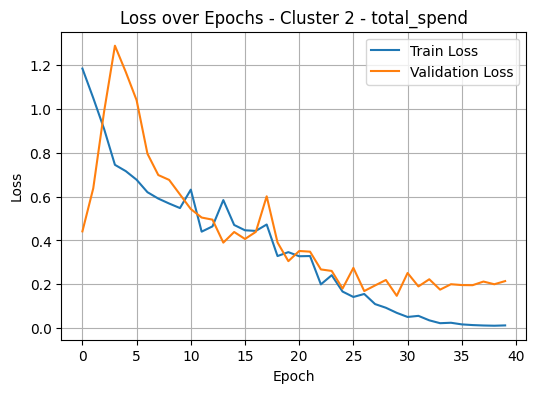

In [25]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

all_val_losses = []

# Cihaz ayarı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility ayarları
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(3)

# Dataset class
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# LSTM modeli
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# Sliding window
def create_sliding_windows(df, features, target, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df[features].iloc[i:i+window_size].values)
        y.append(df[target].iloc[i+window_size])
    return np.array(X), np.array(y).reshape(-1, 1)

# Bootstrapping
def bootstrap_samples(X, y, factor=3):
    indices = np.random.randint(0, len(X), size=factor * len(X))
    X_boot = X[indices]
    y_boot = y[indices]
    return X_boot, y_boot

# Ana eğitim fonksiyonu
def train_seq2seq_lstm(df, cluster_name, window=3, num_epochs=40, batch_size=8, lr=0.01):
    features = ["ipsos_mean", "cons_conf_mean"]
    target = "total_spend"

    X, y = create_sliding_windows(df, features, target, window_size=window)
    X, y = bootstrap_samples(X, y, factor=2)

    # Normalize
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_shape = X.shape
    X = x_scaler.fit_transform(X.reshape(-1, X_shape[2])).reshape(X_shape)
    y = y_scaler.fit_transform(y)

    # Split
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    train_dataset = SequenceDataset(X_train, y_train)
    test_dataset = SequenceDataset(X_test, y_test)

    # Seedli DataLoader için generator
    generator = torch.Generator()
    generator.manual_seed(42)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = LSTMRegressor(input_dim=X.shape[2]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses= [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            loss = criterion(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation loss
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                output = model(x_batch)
                loss = criterion(output, y_batch)
                epoch_val_loss += loss.item()
        val_losses.append(epoch_val_loss / len(test_loader))
    all_val_losses.append((cluster_name + " - LSTM", val_losses.copy()))

    # Evaluation
    model.eval()
    y_preds, y_true = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            output = model(x_batch).cpu().numpy()
            y_preds.extend(output)
            y_true.extend(y_batch.numpy())

    rmse = np.sqrt(mean_squared_error(y_true, y_preds))
    mae = mean_absolute_error(y_true, y_preds)
    r2 = r2_score(y_true, y_preds)

    print(f"Cluster: {cluster_name}")
    print(f"Normalized Scale -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    print("-" * 40)

    # Loss plot
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title(f"Loss over Epochs - {cluster_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

for i in range(3):
    df = pd.read_csv(f"../datasets/cluster_{i}_series.csv")
    train_seq2seq_lstm(df, f"Cluster {i} - total_spend", window=3)


Cluster: Cluster 0 - total_transactions
Normalized Scale -> RMSE: 0.0884, MAE: 0.0692, R²: 0.9938
----------------------------------------


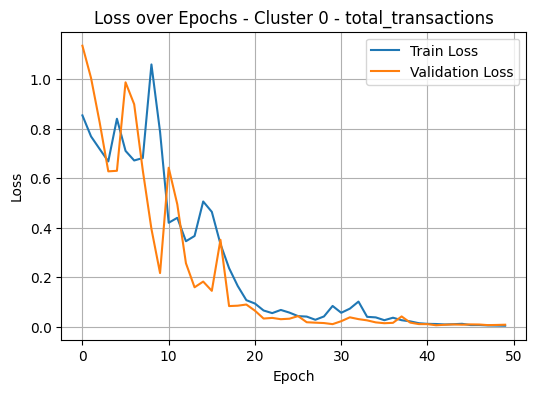

Cluster: Cluster 1 - total_transactions
Normalized Scale -> RMSE: 0.1988, MAE: 0.1275, R²: 0.4065
----------------------------------------


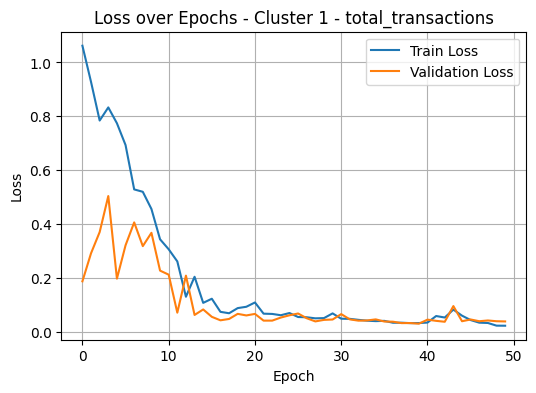

Cluster: Cluster 2 - total_transactions
Normalized Scale -> RMSE: 0.0639, MAE: 0.0335, R²: 0.9750
----------------------------------------


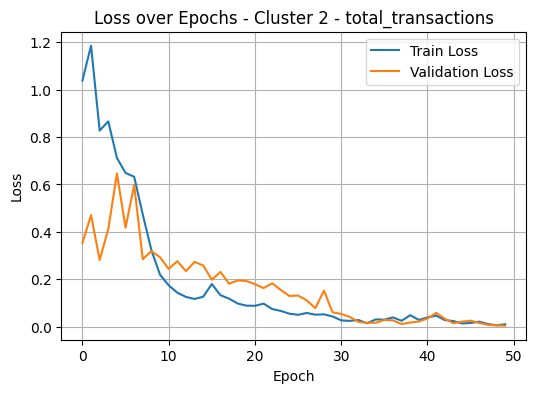

In [26]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cihaz ayarı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility ayarları
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(3)

# Dataset class
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# LSTM modeli
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# Sliding window
def create_sliding_windows(df, features, target, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df[features].iloc[i:i+window_size].values)
        y.append(df[target].iloc[i+window_size])
    return np.array(X), np.array(y).reshape(-1, 1)

# Bootstrapping
def bootstrap_samples(X, y, factor=3):
    indices = np.random.randint(0, len(X), size=factor * len(X))
    X_boot = X[indices]
    y_boot = y[indices]
    return X_boot, y_boot

# Ana eğitim fonksiyonu
def train_seq2seq_lstm(df, cluster_name, window=3, num_epochs=50, batch_size=8, lr=0.01):
    features = ["ipsos_mean", "cons_conf_mean"]
    target = "total_transactions"

    X, y = create_sliding_windows(df, features, target, window_size=window)
    X, y = bootstrap_samples(X, y, factor=3)

    # Normalize
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_shape = X.shape
    X = x_scaler.fit_transform(X.reshape(-1, X_shape[2])).reshape(X_shape)
    y = y_scaler.fit_transform(y)

    # Split
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    train_dataset = SequenceDataset(X_train, y_train)
    test_dataset = SequenceDataset(X_test, y_test)

    # Seedli DataLoader için generator
    generator = torch.Generator()
    generator.manual_seed(42)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = LSTMRegressor(input_dim=X.shape[2]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            loss = criterion(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation loss
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                output = model(x_batch)
                loss = criterion(output, y_batch)
                epoch_val_loss += loss.item()
        val_losses.append(epoch_val_loss / len(test_loader))
    all_val_losses.append((cluster_name + " - LSTM", val_losses.copy()))

    # Evaluation
    model.eval()
    y_preds, y_true = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            output = model(x_batch).cpu().numpy()
            y_preds.extend(output)
            y_true.extend(y_batch.numpy())

    rmse = np.sqrt(mean_squared_error(y_true, y_preds))
    mae = mean_absolute_error(y_true, y_preds)
    r2 = r2_score(y_true, y_preds)

    print(f"Cluster: {cluster_name}")
    print(f"Normalized Scale -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    print("-" * 40)

    # Loss plot
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title(f"Loss over Epochs - {cluster_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

for i in range(3):
    df = pd.read_csv(f"../datasets/cluster_{i}_series.csv")
    train_seq2seq_lstm(df, f"Cluster {i} - total_transactions", window=3)


Cluster: Cluster 0 - total_spend
Normalized Scale -> RMSE: 0.2073, MAE: 0.1675, R²: 0.9792
----------------------------------------


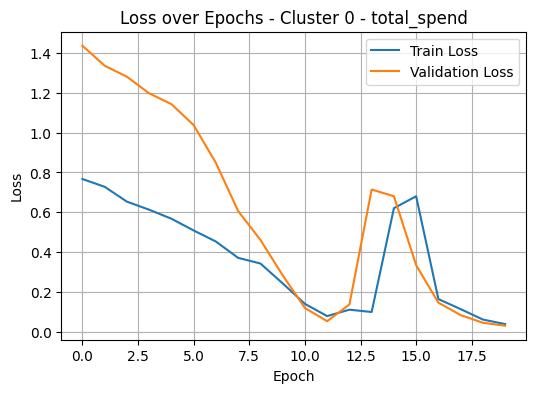

Cluster: Cluster 1 - total_spend
Normalized Scale -> RMSE: 0.1841, MAE: 0.1245, R²: 0.7423
----------------------------------------


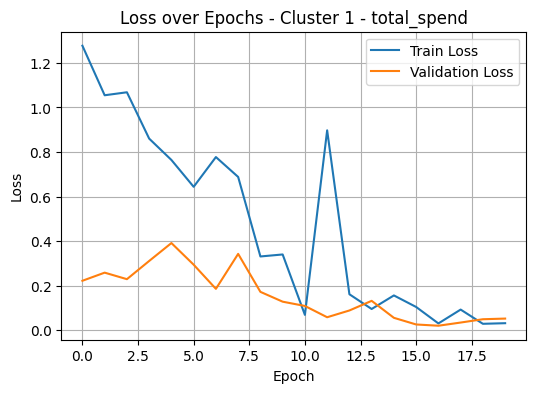

Cluster: Cluster 2 - total_spend
Normalized Scale -> RMSE: 0.4234, MAE: 0.2145, R²: 0.4500
----------------------------------------


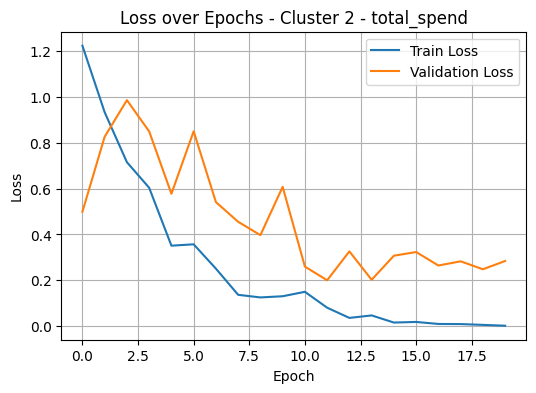

In [27]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cihaz ayarı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility ayarları
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(3)

# Dataset class
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# N-BEATS modeli
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(NBeatsBlock, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.backcast = nn.Linear(hidden_size, input_size)
        self.forecast = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        return self.backcast(x), self.forecast(x)

class NBeatsNet(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_blocks=3):
        super(NBeatsNet, self).__init__()
        self.blocks = nn.ModuleList(
            [NBeatsBlock(input_size, hidden_size) for _ in range(num_blocks)]
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        residual = x
        forecast = 0
        for block in self.blocks:
            backcast, block_forecast = block(residual)
            residual = residual - backcast
            forecast = forecast + block_forecast
        return forecast

# Sliding window
def create_sliding_windows(df, features, target, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df[features].iloc[i:i+window_size].values)
        y.append(df[target].iloc[i+window_size])
    return np.array(X), np.array(y).reshape(-1, 1)

# Bootstrapping
def bootstrap_samples(X, y, factor=3):
    indices = np.random.randint(0, len(X), size=factor * len(X))
    X_boot = X[indices]
    y_boot = y[indices]
    return X_boot, y_boot

# Ana eğitim fonksiyonu
def train_seq2seq_lstm(df, cluster_name, window=3, num_epochs=20, batch_size=8, lr=0.005):
    features = ["ipsos_mean", "cons_conf_mean"]
    target = "total_spend"

    X, y = create_sliding_windows(df, features, target, window_size=window)
    X, y = bootstrap_samples(X, y, factor=2)

    # Normalize
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_shape = X.shape
    X = x_scaler.fit_transform(X.reshape(-1, X_shape[2])).reshape(X_shape)
    y = y_scaler.fit_transform(y)

    # Split
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    train_dataset = SequenceDataset(X_train, y_train)
    test_dataset = SequenceDataset(X_test, y_test)

    generator = torch.Generator()
    generator.manual_seed(42)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = NBeatsNet(input_size=window * X.shape[2]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            loss = criterion(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation loss
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                output = model(x_batch)
                loss = criterion(output, y_batch)
                epoch_val_loss += loss.item()
        val_losses.append(epoch_val_loss / len(test_loader))
    all_val_losses.append((cluster_name + " - N-BEATS", val_losses.copy()))

    # Evaluation
    model.eval()
    y_preds, y_true = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            output = model(x_batch).cpu().numpy()
            y_preds.extend(output)
            y_true.extend(y_batch.numpy())

    rmse = np.sqrt(mean_squared_error(y_true, y_preds))
    mae = mean_absolute_error(y_true, y_preds)
    r2 = r2_score(y_true, y_preds)

    print(f"Cluster: {cluster_name}")
    print(f"Normalized Scale -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    print("-" * 40)

    # Loss plot
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title(f"Loss over Epochs - {cluster_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

for i in range(3):
    df = pd.read_csv(f"../datasets/cluster_{i}_series.csv")
    train_seq2seq_lstm(df, f"Cluster {i} - total_spend", window=3)


Cluster: Cluster 0 - total_transactions
Normalized Scale -> RMSE: 0.2217, MAE: 0.1799, R²: 0.9608
----------------------------------------


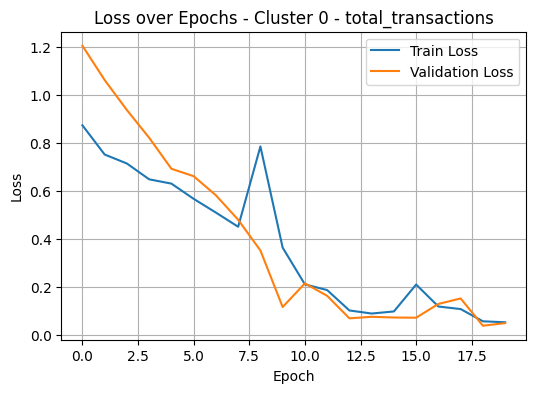

Cluster: Cluster 1 - total_transactions
Normalized Scale -> RMSE: 0.2100, MAE: 0.1420, R²: 0.3380
----------------------------------------


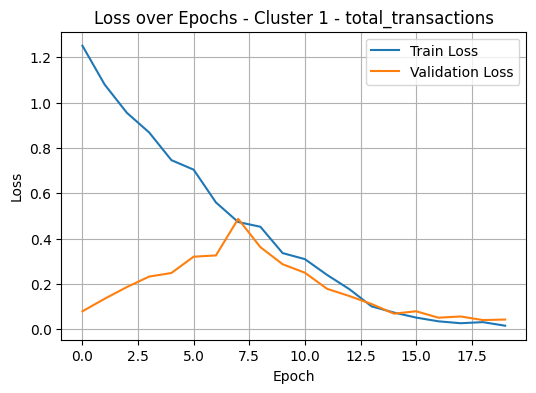

Cluster: Cluster 2 - total_transactions
Normalized Scale -> RMSE: 0.1155, MAE: 0.0883, R²: 0.9182
----------------------------------------


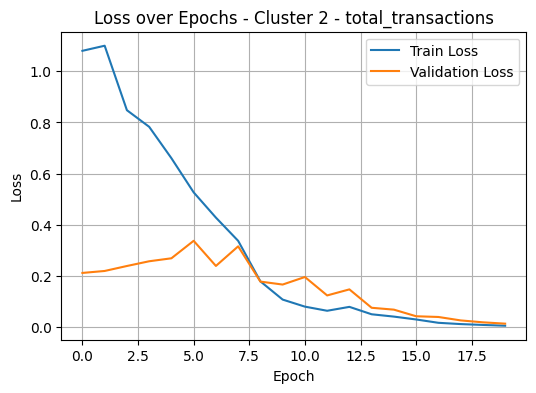

In [28]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cihaz ayarı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility ayarları
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(3)

# Dataset class
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# N-BEATS modeli
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(NBeatsBlock, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.backcast = nn.Linear(hidden_size, input_size)
        self.forecast = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        return self.backcast(x), self.forecast(x)

class NBeatsNet(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_blocks=3):
        super(NBeatsNet, self).__init__()
        self.blocks = nn.ModuleList(
            [NBeatsBlock(input_size, hidden_size) for _ in range(num_blocks)]
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        residual = x
        forecast = 0
        for block in self.blocks:
            backcast, block_forecast = block(residual)
            residual = residual - backcast
            forecast = forecast + block_forecast
        return forecast

# Sliding window
def create_sliding_windows(df, features, target, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df[features].iloc[i:i+window_size].values)
        y.append(df[target].iloc[i+window_size])
    return np.array(X), np.array(y).reshape(-1, 1)

# Bootstrapping
def bootstrap_samples(X, y, factor=3):
    indices = np.random.randint(0, len(X), size=factor * len(X))
    X_boot = X[indices]
    y_boot = y[indices]
    return X_boot, y_boot

# Ana eğitim fonksiyonu
def train_seq2seq_lstm(df, cluster_name, window=3, num_epochs=20, batch_size=8, lr=0.001):
    features = ["ipsos_mean", "cons_conf_mean"]
    target = "total_transactions"

    X, y = create_sliding_windows(df, features, target, window_size=window)
    X, y = bootstrap_samples(X, y, factor=3)

    # Normalize
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_shape = X.shape
    X = x_scaler.fit_transform(X.reshape(-1, X_shape[2])).reshape(X_shape)
    y = y_scaler.fit_transform(y)

    # Split
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    train_dataset = SequenceDataset(X_train, y_train)
    test_dataset = SequenceDataset(X_test, y_test)

    generator = torch.Generator()
    generator.manual_seed(42)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = NBeatsNet(input_size=window * X.shape[2]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            loss = criterion(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation loss
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                output = model(x_batch)
                loss = criterion(output, y_batch)
                epoch_val_loss += loss.item()
        val_losses.append(epoch_val_loss / len(test_loader))
    all_val_losses.append((cluster_name + " - N-BEATS", val_losses.copy()))

    # Evaluation
    model.eval()
    y_preds, y_true = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            output = model(x_batch).cpu().numpy()
            y_preds.extend(output)
            y_true.extend(y_batch.numpy())

    rmse = np.sqrt(mean_squared_error(y_true, y_preds))
    mae = mean_absolute_error(y_true, y_preds)
    r2 = r2_score(y_true, y_preds)

    print(f"Cluster: {cluster_name}")
    print(f"Normalized Scale -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    print("-" * 40)

    # Loss plot
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title(f"Loss over Epochs - {cluster_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

for i in range(3):
    df = pd.read_csv(f"../datasets/cluster_{i}_series.csv")
    train_seq2seq_lstm(df, f"Cluster {i} - total_transactions", window=3)


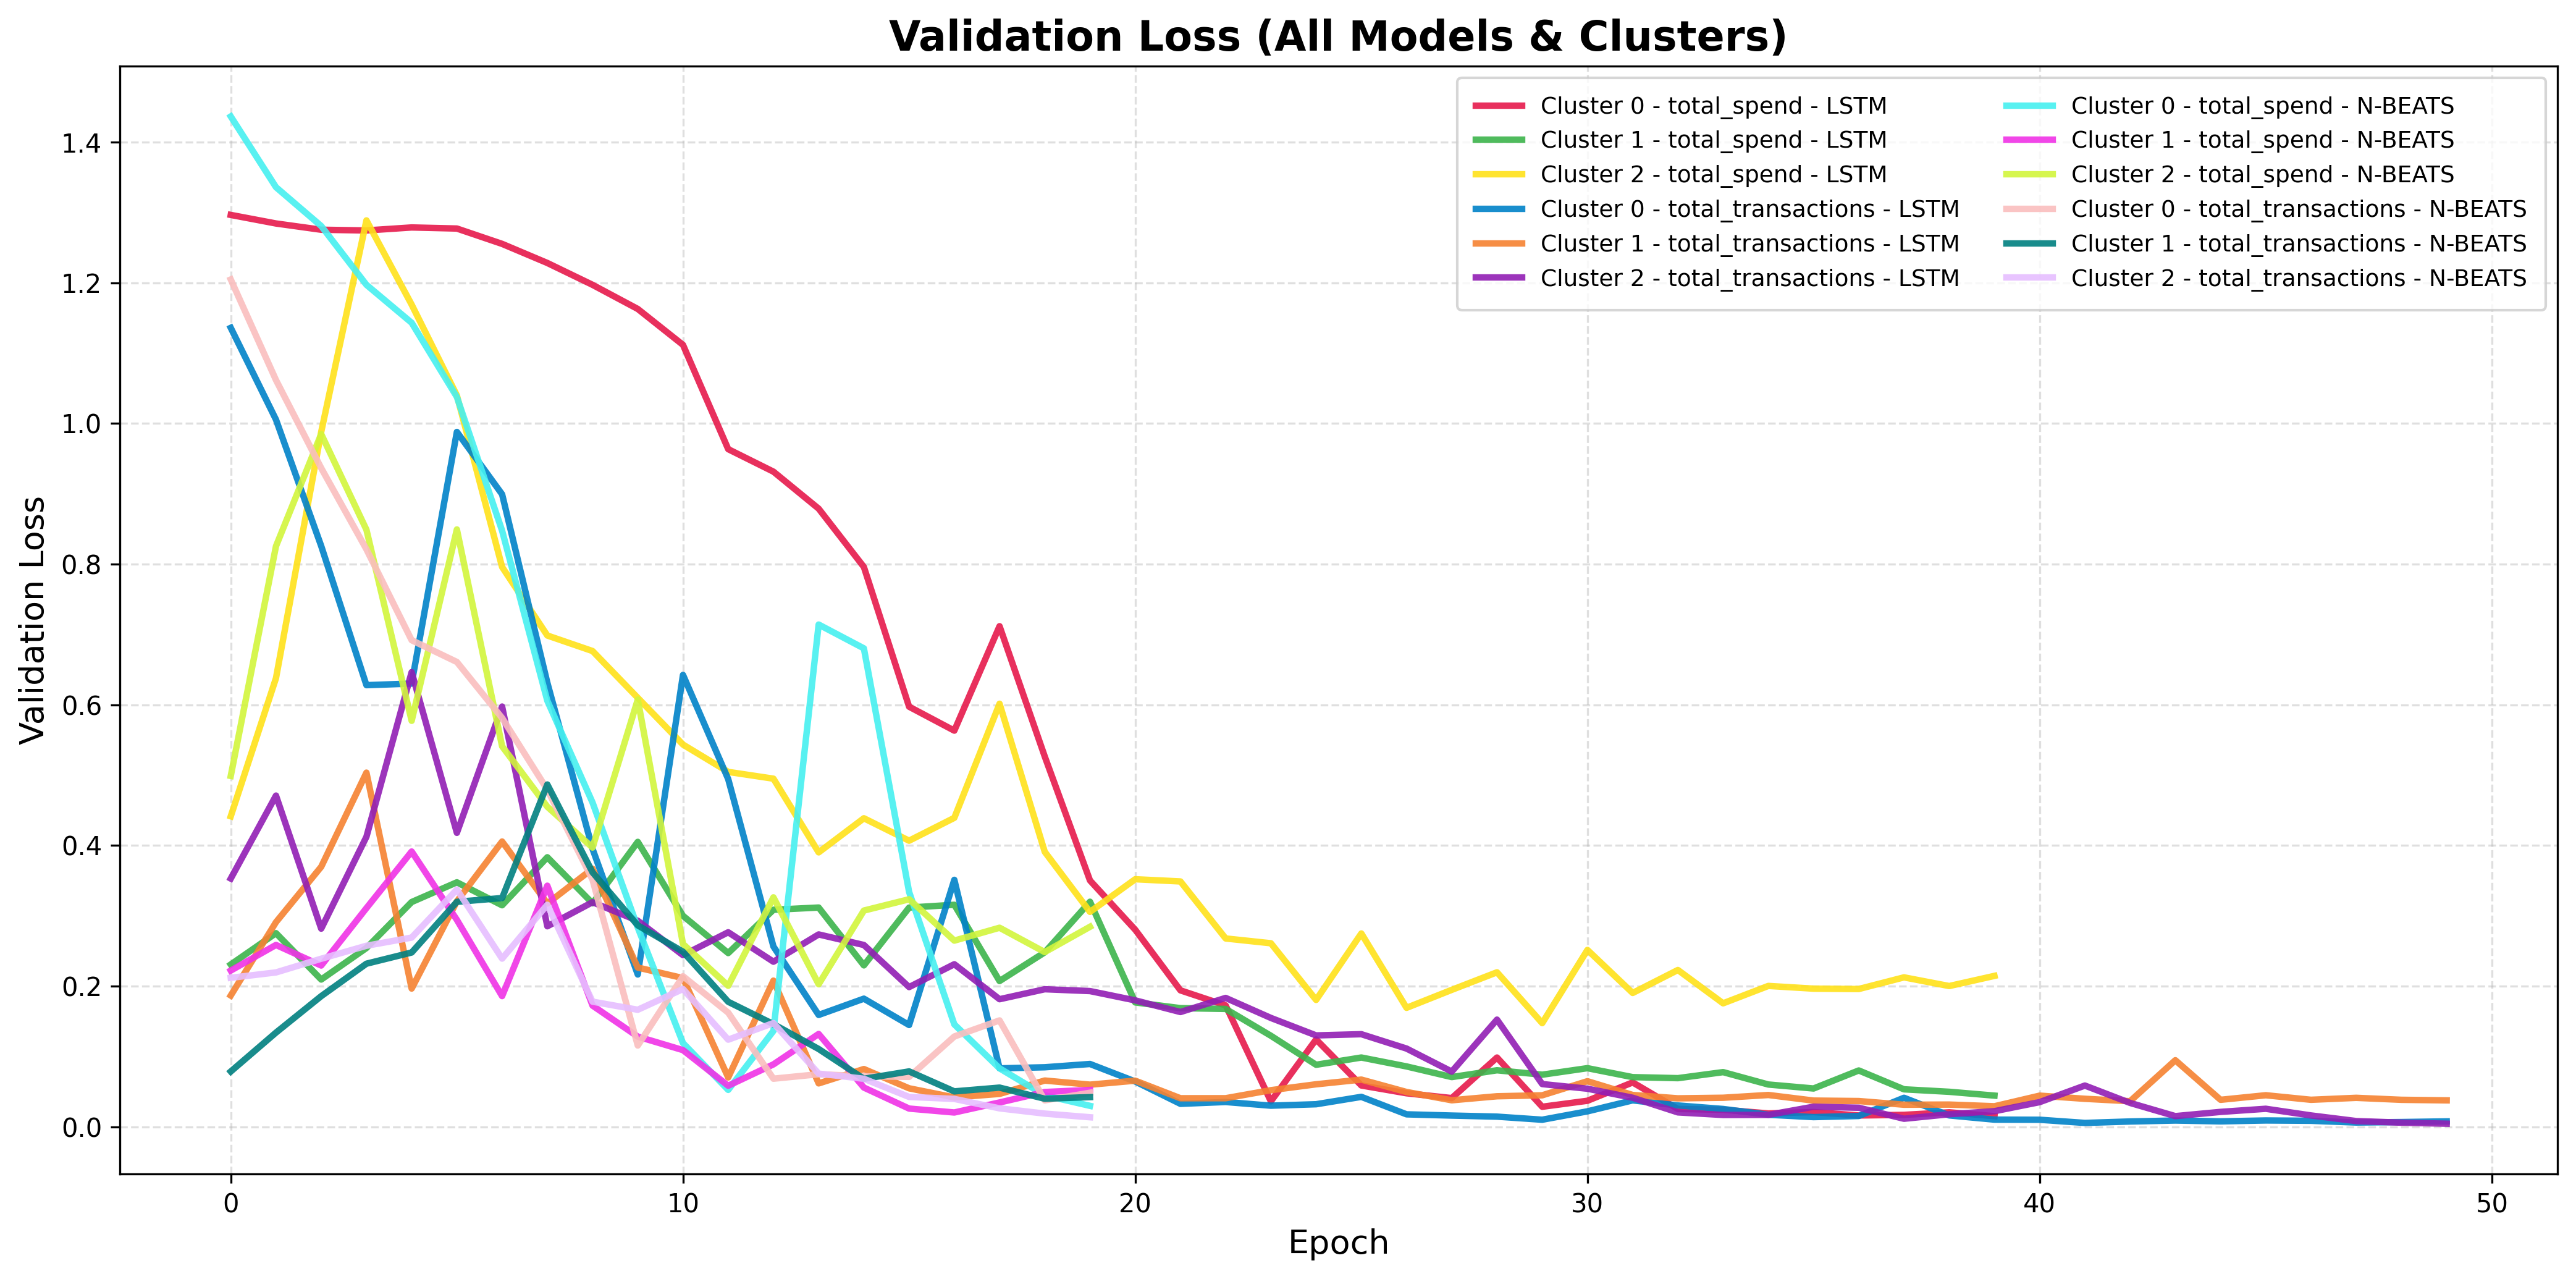

In [33]:
import matplotlib.pyplot as plt

colors = [
    "#e6194b",  # Canlı kırmızı
    "#3cb44b",  # Canlı yeşil
    "#ffe119",  # Sarı (çok parlak)
    "#0082c8",  # Canlı mavi
    "#f58231",  # Parlak turuncu
    "#911eb4",  # Canlı mor
    "#46f0f0",  # Parlak camgöbeği
    "#f032e6",  # Parlak pembe
    "#d2f53c",  # Limon yeşili
    "#fabebe",  # Açık pembe (ama hâlâ canlı)
    "#008080",  # Teal
    "#e6beff"   # Açık mor (ama doygunluğu yüksek)
]

plt.figure(figsize=(14, 7), dpi=300)

for i, (label, losses) in enumerate(all_val_losses):
    color = colors[i % len(colors)]
    plt.plot(
        losses,
        label=label,
        color=color,
        linewidth=2.5,
        alpha=0.9
    )

# Legend düzenleme
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.legend(
    by_label.values(),
    by_label.keys(),
    loc="upper right",
    fontsize=9,
    frameon=True,
    ncol=2,
    borderpad=0.8
)

plt.title("Validation Loss (All Models & Clusters)", fontsize=16, weight='bold')
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("Validation Loss", fontsize=13)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("validation_loss.png", dpi=300)
plt.show()
